In [15]:
# Import relevant packages
import math
import pandas as pd
import numpy as np
import numpy.ma as ma
import datetime
import geopandas as gpd
import shapely
import sys
import pymongo
from pymongo import MongoClient

import plotly.graph_objects as go
import contextily as cx
from tqdm import tqdm
import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from shapely.geometry import Point, Polygon, LineString
import os
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
import plotly.express as px

import json
import pyogrio

from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, RadioButtonGroup,Slider
from bokeh.palettes import brewer

from bokeh.io.doc import curdoc
from bokeh.layouts import widgetbox, row, column, gridplot

# Useful functions below.

In [2]:
def extractDataTwente():
    #twente_21=pd.read_excel(r'C:/Users/MC/OneDrive - Stokhos BV/Stokhos/regiosdata/twente/Twente_ritten2021.xlsx')
    twente_22=pd.read_excel(r'C:/Users/MC/OneDrive - Stokhos BV/Stokhos/regiosdata/twente/Twente_ritten2022.xlsx')
    #twente_21 = np.array(twente_21)
    twente_22 = np.array(twente_22)

    #twe_21=np.delete(twente_21,[0,3,4,5,6,7,8,9,10,11,12,13,14,17,18,19,20,21,22,23,24,25,26,27,28,-2,-1],axis=1)
    twe_22=np.delete(twente_22,[0,3,4,5,6,7,8,11,12,13,14,15,16,17,18,19,20,21,22,23,25,26,27,28,29,30,-3,-2,-1],axis=1)
    #twe_whole = np.vstack((np.array(twe_21),np.array(twe_22)))
    twe_whole = twe_22
    invalid_timestamps=[]
    for i in tqdm(range(len(twe_whole))):
        if (twe_whole[i,1]-twe_whole[i,0]).total_seconds()>3600: #time delta between call and ride assignment toolong 'f >1h
            invalid_timestamps.append(i)
    clean_set=np.delete(twe_whole,invalid_timestamps,axis=0) #only records correct calls regardeless of ridetype

    clean_set=clean_set[[(type(clean_set[j,4])==str)&(type(clean_set[j,2])!=str) for j in range(len(clean_set))]]
    df=pd.DataFrame({'CallTime':clean_set[:,0],'lat':clean_set[:,2].tolist(),'lon':clean_set[:,3].tolist(),'urgency':clean_set[:,4].tolist()})
    gdf=gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))
    gdf.crs='epsg:4326'

    return gdf

def extractDataFLGV():

    # Read in data for GGD locally. Maybe implement it from link (sharepoint)
    data_fld=pd.read_excel(r'C:/Users/MC/OneDrive - Stokhos BV/Stokhos/regiosdata/fgm/FLD_08_21-09_22.xlsx')
    #data_gvs=pd.read_excel(r'C:/Users/MC/OneDrive - Stokhos BV/Stokhos/regiosdata/fgm/GVS_08_21-09_22.xlsx')
    #flgv_post=np.vstack((np.array(data_fld)[:,2:],np.array(data_gvs)[:,2:]))
    flgv_post=np.array(data_fld)[:,2:]
    flgv_post=np.delete(flgv_post,[2,3,4,5,6,7,8,12,13,14,15,16,17,18,19,20,21,22],axis=1)

    # Clean dataset from invalid runs
    invalid_timestamps=[]
    for i in tqdm(range(len(flgv_post))):
        if (flgv_post[i,1]-flgv_post[i,0]).total_seconds()>3600: #time delta between call and ride assignment toolong 'f >1h
            invalid_timestamps.append(i)
    flgv_post = pd.DataFrame(np.delete(flgv_post,invalid_timestamps,axis=0)) #only records correct calls regardeless of ridetype
    flgv_post.rename(columns={2:'Station',3:'xcoord',4:'ycoord',5:'urgency',0:'CallTime'},inplace=True)

    # Select incidents that happened inside the region -- GFV here
    gdf = gpd.GeoDataFrame(flgv_post, geometry=gpd.points_from_xy(flgv_post.xcoord, flgv_post.ycoord))
    gdf.crs='epsg:28992'
    gdf=gdf.to_crs(epsg=4326)

    return gdf


def make_hexagon_grids(code):

    # Read in hexagon centres from local file -- maybe implement read directly from link/sharepoint.
    hex_centres = [None]*4 # Initialize a list with 4 None elements
    for i, region in enumerate(['Flevoland Gooi Vecht (FGM)','Zuid Holland Zuid (ZHZ)','Twente','IJsselland']):
        hex_centres[i] = pd.read_excel(r'C:/Users/MC/OneDrive - Stokhos BV/Stokhos/geodata/Hex_coords_4regions.xlsx',region).drop('Unnamed: 0',axis=1).drop(0).reset_index().drop('index',axis=1)
        hex_centres[i] = hex_centres[i].rename(columns={hex_centres[i].columns[1]: "lon", hex_centres[i].columns[0]: "lat"})
        hex_centres[i] = hex_centres[i].reindex(columns=hex_centres[i].columns[::-1])
        hex_centres[i].sort_values(by=['lon', 'lat']).reset_index().drop('index',axis=1)
        hex_centres[i]['hexID'] = hex_centres[i].reset_index().index
    
    center_coords = hex_centres[code]
    print('hex centres ready')
    # Define the size of the hexagons    
    avg_distance=np.mean([np.abs(center_coords.lon.loc[i+1]-center_coords.lon.loc[i]) for i in range(6)])
    rad_km = avg_distance / np.sqrt(3) * 111.320 * np.cos(math.radians(center_coords.loc[5].lat))
    hexagons = []
    hex_vertices = []
    for j in tqdm(range(len(center_coords))):
        center_km = [center_coords.loc[j].lon * 111.320 * np.cos(math.radians(center_coords.loc[j].lat)) , center_coords.loc[j].lat * 110.574]
        vertices = []  
        for i in range(6):
            angle = np.pi/6 + np.pi/3 * i
            # find new vertices coords and immediately convert back to deg 
            ver_lon = (center_km[0] + rad_km * np.cos(angle)) / (111.320 * np.cos(math.radians(center_coords.loc[j].lat)))  
            ver_lat = (center_km[1] + rad_km * np.sin(angle)) / 110.574
            vertices.append((ver_lon,ver_lat))

        hexagons.append(Polygon(vertices))
        
    # Create two empty grids (geo-dataframes) to fill with A1 and A2 data 
    hex_grid_A1=gpd.GeoDataFrame({'geometry': hexagons })
    hex_grid_A1.crs='epsg:4326'
    hex_grid_A2=gpd.GeoDataFrame({'geometry': hexagons })
    hex_grid_A2.crs='epsg:4326'

    hex_grids=[hex_grid_A1,hex_grid_A2]

    return hex_grids

done
done
dataframe obtained.


100%|██████████| 8/8 [00:26<00:00,  3.26s/it]


The average (mean) number of advices per incident is 599 while the median number of advices is 208.
The average (mean) number of unique advices per incident is 4.72 while the median number of unique advices is 4.
Between 08/01/2024 and 08/05/2024, the number of unique dispatch advices for urgencies A0/A1/A2 is 2540. The total number of dispatch advices for A-incidents is 336375.
The average (mean) number of unique daily advices is 508.0.
done
done


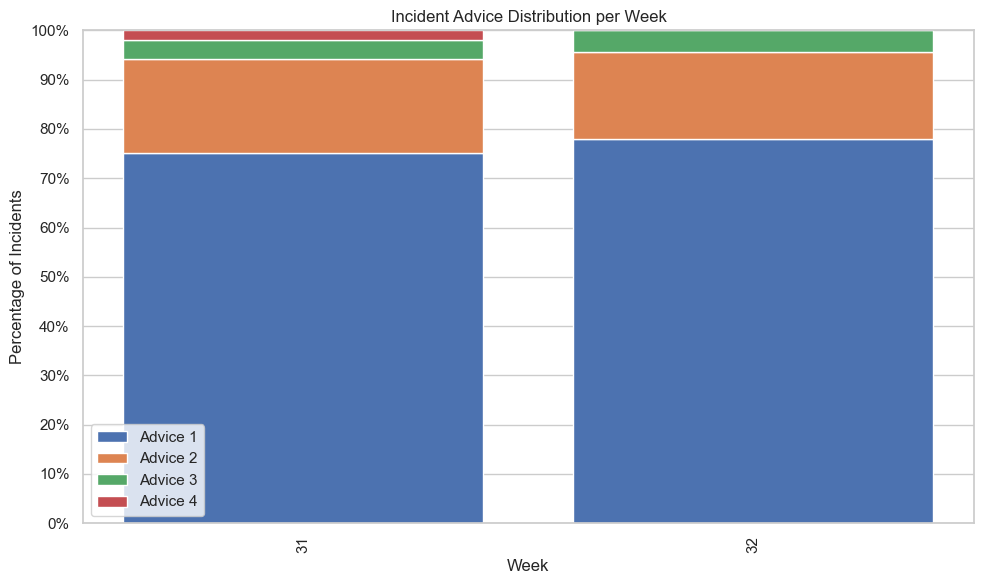

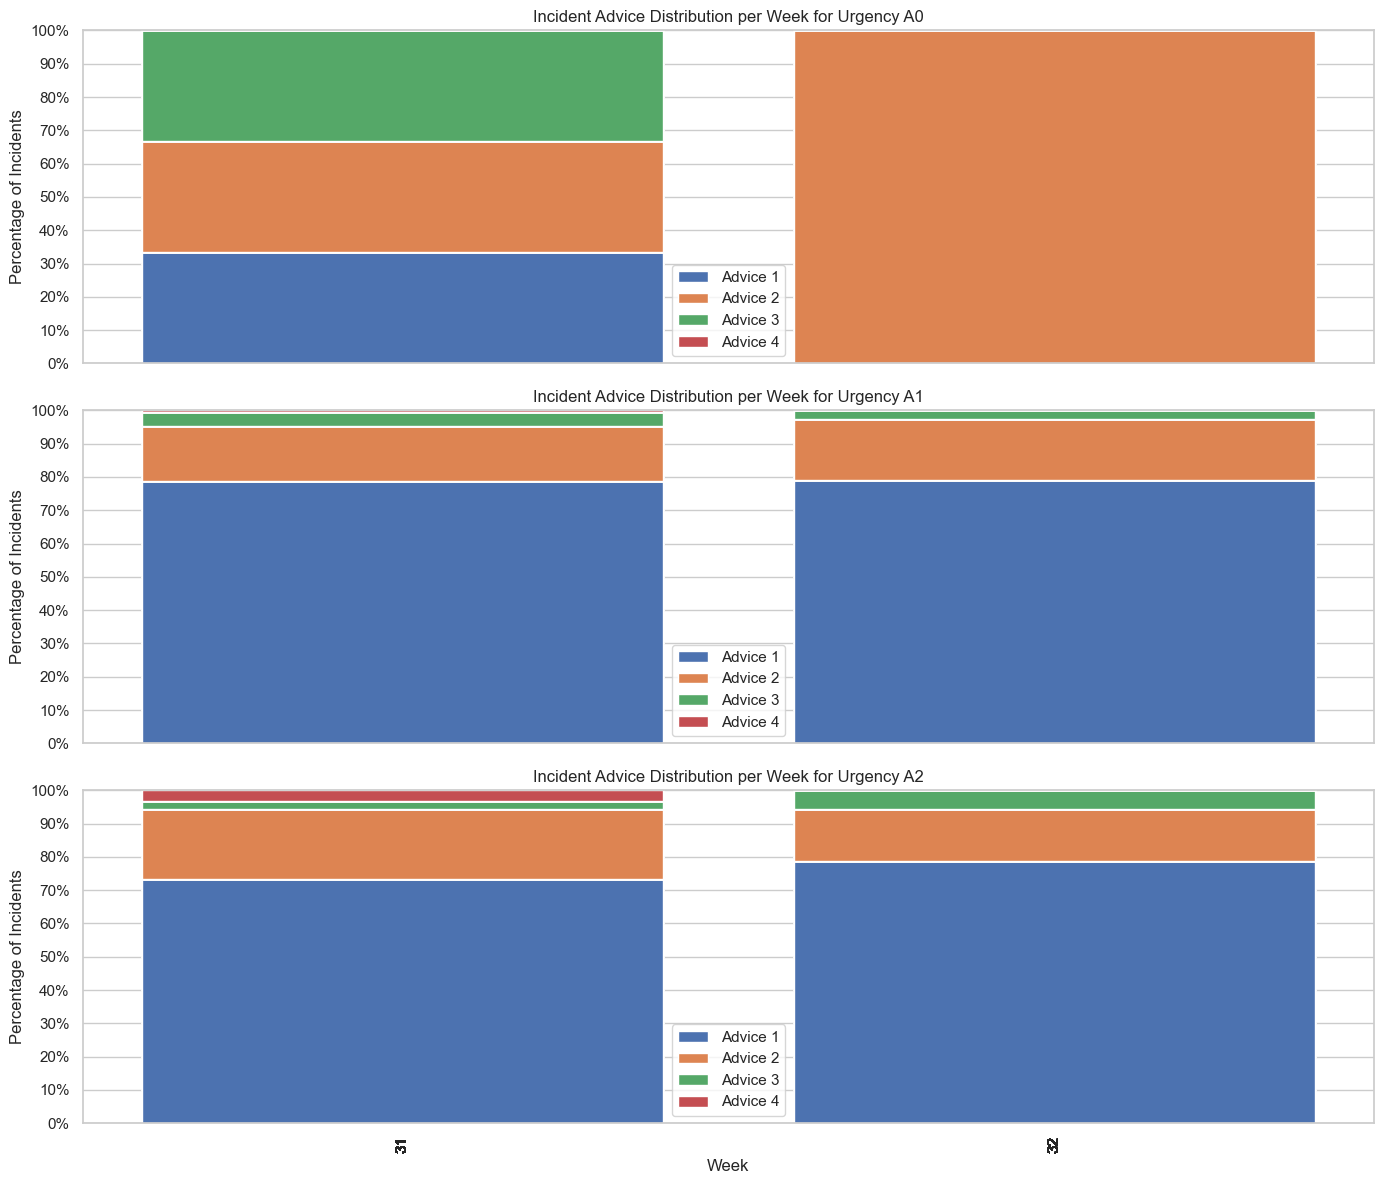

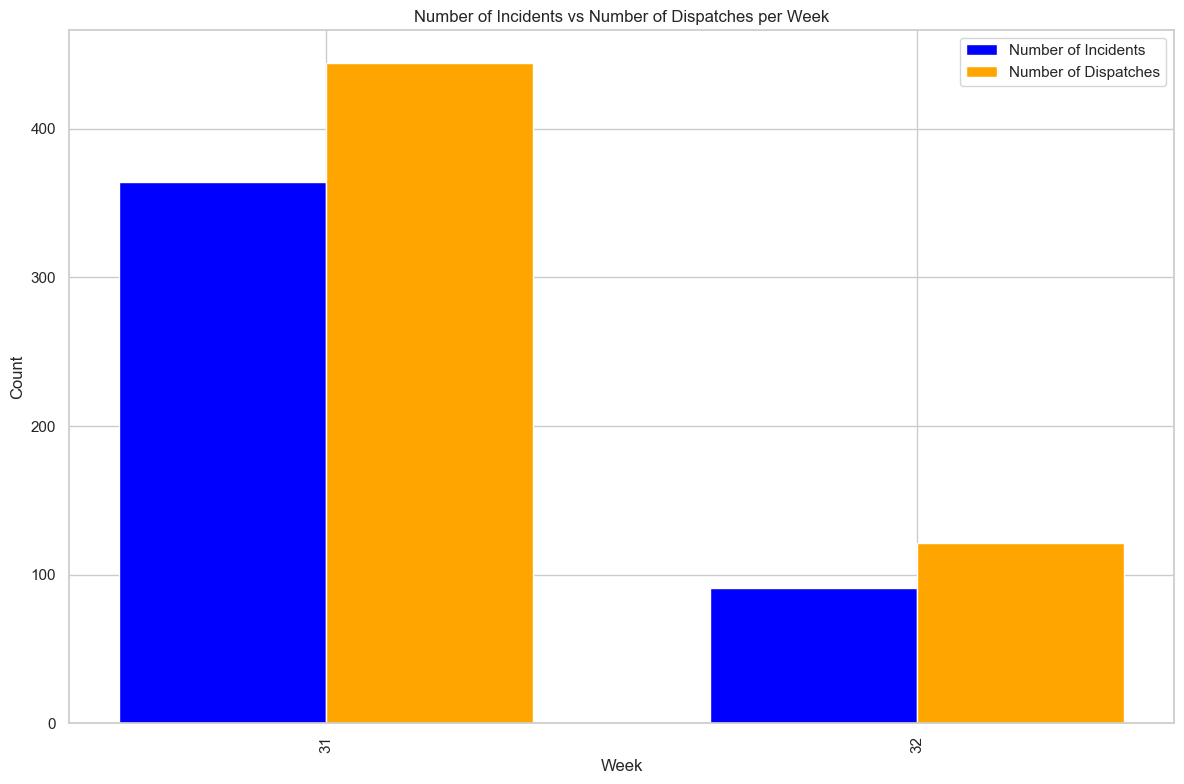

done
done
dataframe obtained.


100%|██████████| 8/8 [00:24<00:00,  3.07s/it]


The average (mean) number of advices per incident is 599 while the median number of advices is 208.
The average (mean) number of unique advices per incident is 4.72 while the median number of unique advices is 4.
Between 08/01/2024 and 08/05/2024, the number of unique dispatch advices for urgencies A0/A1/A2 is 2540. The total number of dispatch advices for A-incidents is 336375.
The average (mean) number of unique daily advices is 508.0.
done
done


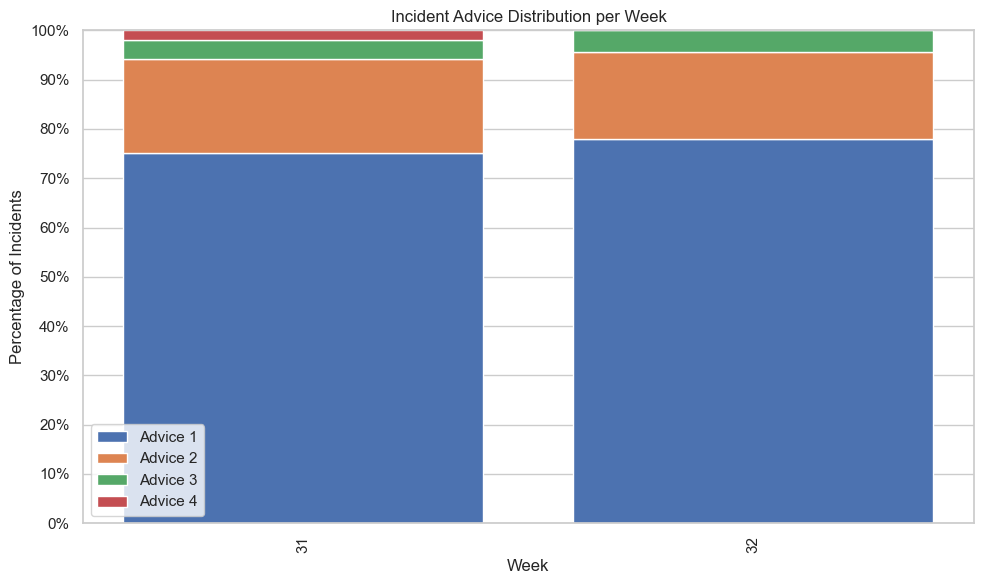

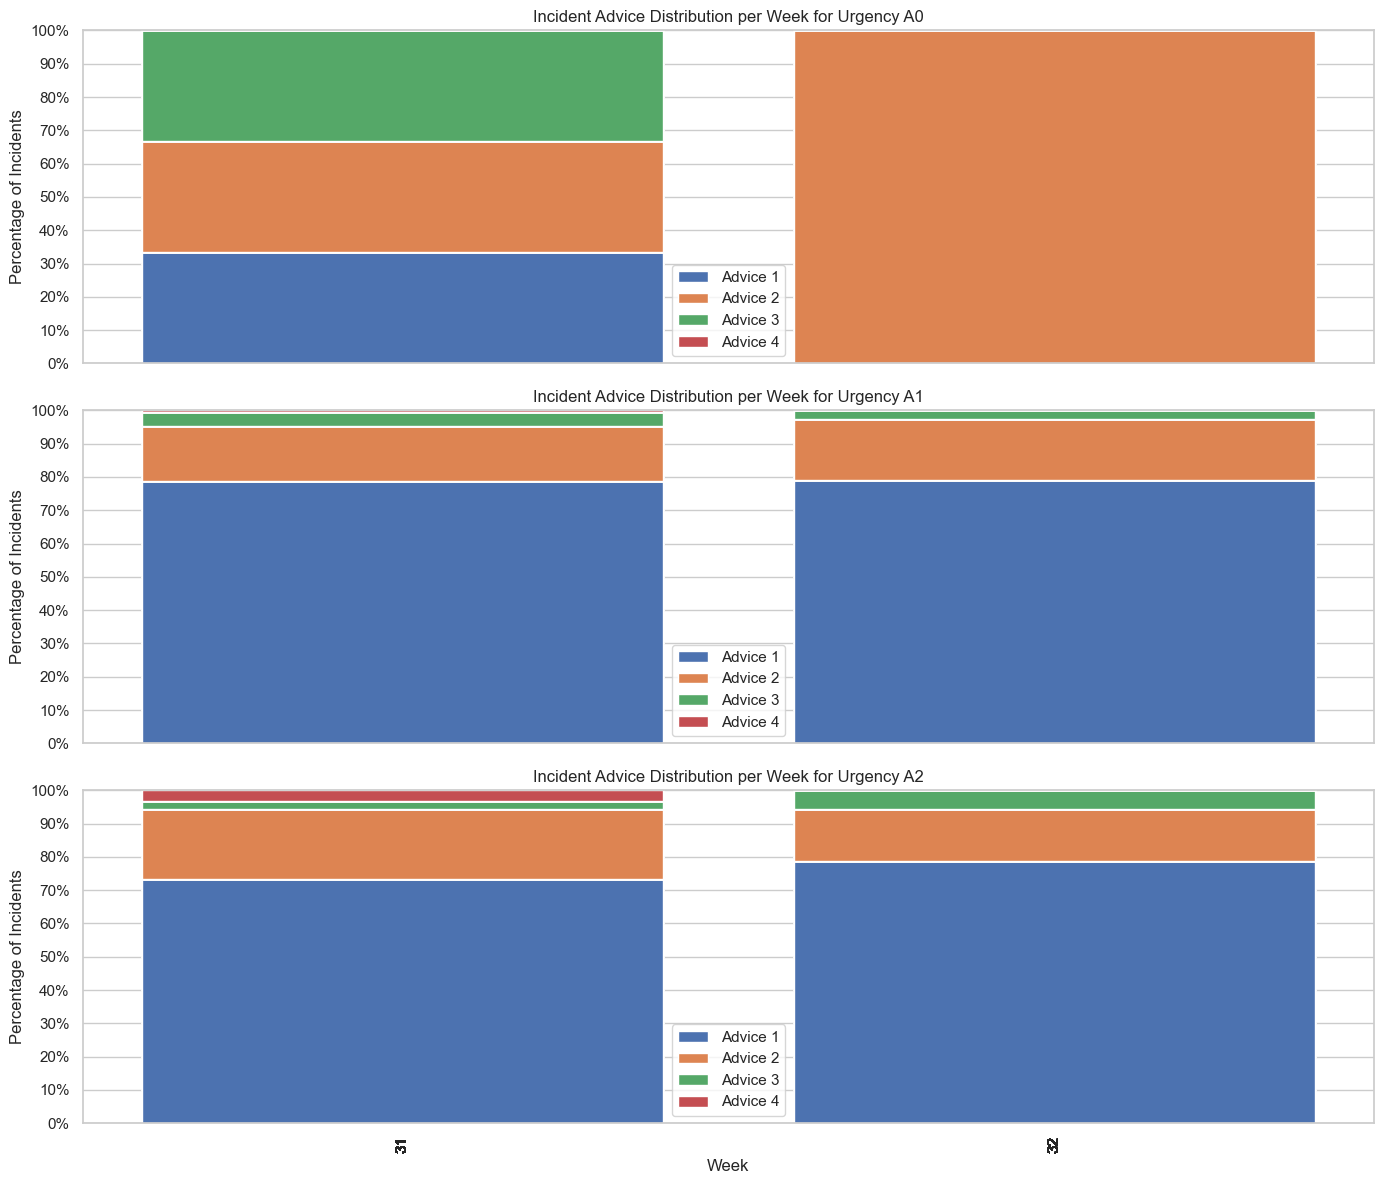

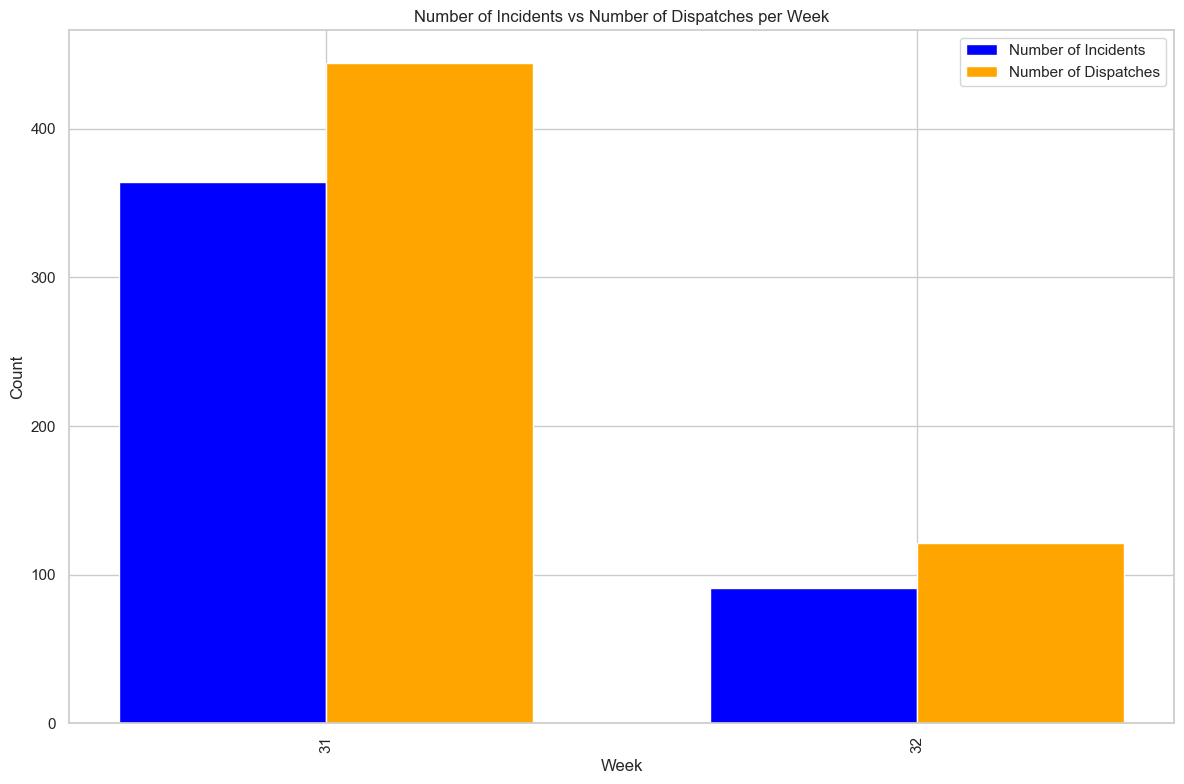

In [1]:
from utilsMongoFuns import *
mongoDBimportTwente(8,1,8,5,1)

# New Cell Below

In [94]:
# Import data on 1) gemeenten
geemapNL=gpd.read_file(r'C:/Users/MC/OneDrive - Stokhos BV/Stokhos/geodata/gadm41_NLD_2.json')
geemapNLL=geemapNL.loc[geemapNL.ENGTYPE_2=='Municipality'] #excludes waterbodies

# 2) GGd regions
ggdmap=gpd.read_file(r'C:/Users/MC/OneDrive - Stokhos BV/Stokhos/geodata/GGD_Regiogrenzen.json')

# 3) stations
regionCode = int(input("Insert 1 for FLGV and 2 for Twente:_____"))
regios_dict = {1:"FLGV",2:"Twente"}
# Give choice of num days and num months to make plot
test_months= int(input("how many test months?"))
test_days  = int(input("how many test days?"))

if regionCode==1:
    stationinfo=pd.read_excel(r'C:/Users/MC/OneDrive - Stokhos BV/Stokhos/regiosdata/fgm/FLGVregio_info.xlsx','Station FLGV')
    stationinfo.columns = stationinfo.iloc[0]
    stationinfo=stationinfo.drop(stationinfo.columns[0],axis=1)
    stationinfo=stationinfo.iloc[1:]
    # municiplaities FLGV
    fldgemten=[geemapNL['NAME_2'][i] for i in range(len(geemapNL)) if geemapNL['NAME_1'][i]=='Flevoland']
    gvs_gemten=['Blaricum','GooiseMeren','Hilversum','Huizen','Laren','Weesp','Wijdemeren']
    gementen=fldgemten+gvs_gemten 
    # retrieve datasets locally (FLGV)
    incidents_gdf = extractDataFLGV()
    hexgrids = make_hexagon_grids(0)
elif regionCode==2:
    stationinfo=pd.read_excel(r'C:/Users/MC/OneDrive - Stokhos BV/Stokhos/regiosdata/twente/Twente_stats.xlsx')
    # Municipalities Twente
    gementen=['Almelo','Borne','Dinkelland','Enschede','Haaksbergen','Hellendoorn','Hengelo','HofvanTwente','Losser','Oldenzaal','Rijssen','Tubbergen','Twenterand','Wierden']
    # retrieve datasets locally (TWENTE)
    incidents_gdf = extractDataTwente()
    hexgrids = make_hexagon_grids(2)
else:
    print("must insert 1 or 2")
print(f'hexagons ready for {regios_dict[regionCode]}')

# 4) stations GDF taking dataframe 'stationinfo' from 'if selected ggd regio'
statgdf=gpd.GeoDataFrame(stationinfo, geometry=gpd.points_from_xy(stationinfo.lon, stationinfo.lat))
statgdf.crs='epsg:4326'

# 5) define GDF for munuicipalities in the selected ggd regio using list 'gementen'
gee_gdf=geemapNL.loc[[geemapNL['NAME_2'][i] in gementen for i in tqdm(range(len(geemapNL)))]]
gee_gdf.loc[:, 'geometry'] = gee_gdf.translate(xoff=-0.005)

# Check that the correct region is being plotted by running
# gee_gdf.plot()

# 6) Only keep incidents that occured inside the region 
gdf_within = incidents_gdf.loc[incidents_gdf.within(gee_gdf.geometry.unary_union)].reset_index().drop('index',axis=1)
gdf_within = gdf_within.assign(lon = gdf_within.geometry.x.to_list())
gdf_within = gdf_within.assign(lat = gdf_within.geometry.y.to_list())

# 7) Fill in hex_grids A1 and A2 with incidents fom the region per month/day
for i,urg in enumerate(['A1','A2']):
    hex_grid=hexgrids[i]
    for month in tqdm(range(1,int(test_months)+1), desc="Filling grid with incs"):
        for weekday in range(test_days):
            ridesMonthDay = gdf_within[(gdf_within.urgency==f'{urg}') & (gdf_within['CallTime'].dt.weekday==weekday)  & (gdf_within['CallTime'].dt.month==month)]
            # normalisation is number of mondays,sundays ets in any given month.
            normalisation = len(np.unique(gdf_within[(gdf_within['CallTime'].dt.weekday==weekday)  & (gdf_within['CallTime'].dt.month==month)].CallTime.dt.date))            
            if normalisation==0: 
                normalisation=1
            # in following line rides are assigned to hexagons
            column_to_insert = [ridesMonthDay.within(hex_grid.loc[i].geometry).sum()/normalisation for i in range(len(hex_grid))]
            hex_grid.insert(np.shape(hex_grid)[1],f"month:{month}:-day:{weekday+1}",column_to_insert)

# 8) Define a sequential multi-hue color palette and reverse color order so that dark blue is highest obesity.
Day_Labels = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
Month_Labels= ["January","February","March","April","May","June","July","August","September","October","November","December"]
palette = brewer['Blues'][8]
palette = palette[::-1]

# 9) Function that returns json_data for the month+weekday+urgency selected 
def json_data(selectedMonth,selectedDay,selectedUrgency):
    # convert from A 1/2 to 0/1 index
    ur = selectedUrgency-1
    # Select urgencyGrid 
    urg_gdf = hexgrids[int(ur)]
    # Pull selected month+day from geodataframe into df
    gdf_mn_day = urg_gdf.filter(like=f"month:{selectedMonth}:-day:{selectedDay}")
    # Retrieve geofeatures (hexagons) from gdf
    gdf = urg_gdf.iloc[:,0:1]
    # Merge the hexagons (gdf) with the data (gdf_mn_day)
    merged =  gpd.GeoDataFrame(pd.concat([gdf,gdf_mn_day],axis=1))
    # Bokeh uses geojson formatting, representing geographical features, with json
    mergedToLoad=merged.to_json()
    # Convert to json
    merged_json = json.loads(mergedToLoad)
    # Convert to json preferred string-like object 
    json_data = json.dumps(merged_json)
    return json_data
# Input geojson source that contains features for starting plot when opening application
geosource = GeoJSONDataSource(geojson = json_data(1,1,2))

# 10) Define the callback function: update_plot which obv updates plots with values selcted on applet
def update_plot(attr, old, new):

    month = mon_slider.value
    #day = day_slider.value
    # Replace slider with RadGroup
    day = rad_group.active + 1
    urgency = urg_slider.value
    new_data = json_data(month,day,urgency)        
    # Update the plot based on the changed inputs
    p = make_plot(month,day,urgency)
    # Update the layout, clear the old document and display the new document
    sliders = column(mon_slider,urg_slider,rad_group)
    layout = column(p, sliders)
    curdoc().clear()
    curdoc().add_root(layout)
    # Update the data
    geosource.geojson = new_data

# 11) Create a plotting function which defines what the plot looks like 
def make_plot(month,day,urgency):    
  
  date=f"month:{month}:-day:{day}"
  urg = urgency - 1
  urg_gdf = hexgrids[int(urg)]
  # Set the format of the colorbar
  min_range = np.array(urg_gdf.filter(like=f"month:{month}:-day:{day}").min())[0]
  max_range = np.array(urg_gdf.filter(like=f"month:{month}:-day:{day}").max())[0]
  # Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
  color_mapper = LinearColorMapper(palette = palette, low = min_range, high = max_range)
  # Create color bar.
  color_bar = ColorBar(color_mapper=color_mapper, label_standoff=18,border_line_color=None, location = (0, 0))

  # Create figure object.
  p = figure(title = f"Average number of A{urgency} incidents on {Day_Labels[day-1]}\'s of {Month_Labels[month]}", 
            plot_height = 650, plot_width = 850,
            toolbar_location = None)
  p.xgrid.grid_line_color = None
  p.ygrid.grid_line_color = None
  p.axis.visible = False
  # Add patch renderer to figure. 
  p.patches('xs','ys', source = geosource, fill_color = {'field' : date, 'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)
  # Specify color bar layout.
  p.add_layout(color_bar, 'right')
  return p

# 12) Call the plotting function 
p = make_plot(1,1,2)

# 13) Add checkbox group for weekdays(trial). 
rad_group = RadioButtonGroup(labels=Day_Labels[:test_days], active=0)
rad_group.on_change('active', update_plot) # rad_group returns [i,j] if i,j clicked, otherwise [].

# Make a MONTHS slider object 
mon_slider = Slider(title = 'Month',start = 1, end = test_months, step = 1, value = 1)
mon_slider.on_change('value', update_plot)
# Make a URGENCY slider object 
urg_slider = Slider(title = 'Urgency A',start = 1, end = 2, step = 1, value = 2)
urg_slider.on_change('value', update_plot)
# Make a column layout of widgetbox(slider) and plot, and add it to the current document
# Display the current document
sliders = column(mon_slider,urg_slider,rad_group)
layout = column(p,sliders)
#layout = column(p, widgetbox(mon_slider), widgetbox(day_slider), widgetbox(urg_slider))
curdoc().add_root(layout)

ValueError: invalid literal for int() with base 10: ''

In [3]:
regios_dict = {1:"FGV",2:"Twente"}
list(regios_dict.values())

['FGV', 'Twente']